# First Model

For this first version, I'm going to set up a basic model using just the following features:
* Book's cluster
* Average rating for that book
* Average (overall) rating given by that user
* Average rating given to books in that cluster by that user

This should give me a starting point that I can iterate over and use to improve performance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
books = pd.read_csv('data/books_step3_output.csv')

In [3]:
books.set_index('book_id', inplace=True)

In [7]:
from sklearn.cluster import KMeans
x = books.drop(['description','title', 'similar_books','authors'], axis=1).values

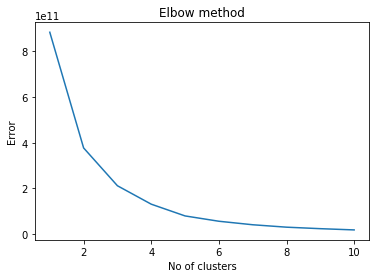

In [8]:
Error = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(x)
    kmeans.fit(x)
    Error.append(kmeans.inertia_)
import matplotlib.pyplot as plt
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

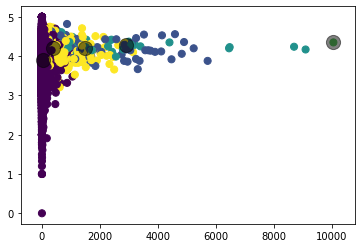

In [19]:
kmeans3 = KMeans(n_clusters=5)
y_kmeans3 = kmeans3.fit_predict(x)
plt.scatter(x[:, 0], x[:, 1], c=y_kmeans3, s=50, cmap='viridis')

centers = kmeans3.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [20]:
books['cluster'] = y_kmeans3

In [21]:
# Drop all columns except: cluster, avg_rating
books = pd.DataFrame(books[['average_rating', 'cluster']])
books.head()

,average_rating,cluster
book_id,,
13571772,4.28,0
35452242,4.05,0
707611,4.06,0
27036536,4.15,0
11827783,3.16,0


In [23]:
books.cluster.value_counts()
### Note for next time....look more into the clustering. why so imbalanced? 
### Is this something I need to try and improve?

0    33038
4      754
1      106
2       26
3        1
Name: cluster, dtype: int64

In [24]:
# Now get/create the user features
reviews = pd.read_csv('data/reviews_step3_output.csv')

In [25]:
# This will be our target variable
users = pd.pivot_table(reviews, index=['user_id','book_id'], values='rating')

In [27]:
users.head()

rating
user_id                          book_id         
00009e46d18f223a82b22da38586b605 23546829       3
000192962b87d560f00b06fdcbd71681 30025791       5
0003a8eb2989503d03ad7ca701898a48 15780398       2
                                 22738008       0
                                 23479604       0

In [28]:
users.shape

(542338, 1)

## User Features

Need to create:
* average rating given by user
* average rating given by user to books in each cluster

In [29]:
# Average rating given by user
averages = users.groupby('user_id')['rating'].mean()

In [30]:
averages.head()

user_id
00009e46d18f223a82b22da38586b605    3.000000
000192962b87d560f00b06fdcbd71681    5.000000
0003a8eb2989503d03ad7ca701898a48    0.666667
0005a08accd53b1e19c52109a1f478cb    3.400000
0006260f85929db85eddee3a0bd0e504    4.375000
Name: rating, dtype: float64

In [45]:
data = pd.merge(left=users, right=averages, on='user_id', how='left')

In [47]:
users['user_avg_rating'] = data['rating_y'].values

In [48]:
users.head()

rating  user_avg_rating
user_id                          book_id                          
00009e46d18f223a82b22da38586b605 23546829       3         3.000000
000192962b87d560f00b06fdcbd71681 30025791       5         5.000000
0003a8eb2989503d03ad7ca701898a48 15780398       2         0.666667
                                 22738008       0         0.666667
                                 23479604       0         0.666667

In [51]:
# Check a middle section to ensure user_avg_rating is the same for each user/row
users.iloc[50:70]

rating  user_avg_rating
user_id                          book_id                          
000e9f4f0334267026d4f92f882b9ac3 29011          4         4.500000
                                 29015          5         4.500000
000efb30c5236d7437c3cdf4bf3e4dc7 608883         1         2.846154
                                 1966703        4         2.846154
                                 6745449        2         2.846154
                                 12728025       2         2.846154
                                 13037817       3         2.846154
                                 14475443       3         2.846154
                                 17287068       3         2.846154
                                 17573665       3         2.846154
                                 18465531       3         2.846154
                                 18528265       3         2.846154
                                 20613678       3         2.846154
                                 23848562       3         2.846154
                                 25733982       4         2.846154
001010815d3b2692435dfc70285d06e4 472331         5         3.666667
                                 4133398        4         3.666667
                                 7269992        2         3.666667
0010d01657baa40ca36423a621229aac 9516           5         5.000000
00125c81ba9ef0504bd02697fdbc3827 4065522        4         4.000000

__Last, but not least, create the average rating per books cluster by user:__
This will be a little tricky. I'll need to add a "book_cluster" column to the users df, then groupby user, book_cluster and find the mean? 

I think that will work...

In [60]:
clusters = []

for (x,y) in users.index:
    try: 
        clusters.append(books.loc[y]['cluster'])
    except:
        clusters.append(np.nan)

In [61]:
users['book_cluster'] = clusters

In [62]:
users.head()

rating  user_avg_rating  \
user_id                          book_id                             
00009e46d18f223a82b22da38586b605 23546829       3         3.000000   
000192962b87d560f00b06fdcbd71681 30025791       5         5.000000   
0003a8eb2989503d03ad7ca701898a48 15780398       2         0.666667   
                                 22738008       0         0.666667   
                                 23479604       0         0.666667   

                                           book_cluster  
user_id                          book_id                 
00009e46d18f223a82b22da38586b605 23546829           NaN  
000192962b87d560f00b06fdcbd71681 30025791           0.0  
0003a8eb2989503d03ad7ca701898a48 15780398           NaN  
                                 22738008           NaN  
                                 23479604           NaN

In [63]:
users.book_cluster.isnull().sum()

156586

In [64]:
users.book_cluster.isnull().sum()/len(users.book_cluster)

0.2887240060626399

In [65]:
users.dropna(inplace=True)

In [66]:
users.shape

(385752, 3)

In [67]:
users.head()

rating  user_avg_rating  \
user_id                          book_id                             
000192962b87d560f00b06fdcbd71681 30025791       5              5.0   
0005a08accd53b1e19c52109a1f478cb 59960          0              3.4   
000700ecd5db3a9b0c4e392ed2e4f70b 11790194       5              5.0   
0008931c0cde961e9c802c5a58196d23 500503         5              5.0   
                                 6081685        5              5.0   

                                           book_cluster  
user_id                          book_id                 
000192962b87d560f00b06fdcbd71681 30025791           0.0  
0005a08accd53b1e19c52109a1f478cb 59960              2.0  
000700ecd5db3a9b0c4e392ed2e4f70b 11790194           0.0  
0008931c0cde961e9c802c5a58196d23 500503             1.0  
                                 6081685            1.0

In [68]:
users['book_cluster'] = users.book_cluster.astype(int)

In [69]:
users.head()

rating  user_avg_rating  \
user_id                          book_id                             
000192962b87d560f00b06fdcbd71681 30025791       5              5.0   
0005a08accd53b1e19c52109a1f478cb 59960          0              3.4   
000700ecd5db3a9b0c4e392ed2e4f70b 11790194       5              5.0   
0008931c0cde961e9c802c5a58196d23 500503         5              5.0   
                                 6081685        5              5.0   

                                           book_cluster  
user_id                          book_id                 
000192962b87d560f00b06fdcbd71681 30025791             0  
0005a08accd53b1e19c52109a1f478cb 59960                2  
000700ecd5db3a9b0c4e392ed2e4f70b 11790194             0  
0008931c0cde961e9c802c5a58196d23 500503               1  
                                 6081685              1

In [74]:
averages = users.groupby(['user_id', 'book_cluster'])['rating'].mean()

In [75]:
averages.iloc[50:70]

user_id                           book_cluster
00348cd61b64224c121e5292d0f1656c  4               4.000000
003686f6755b070f0811dd14690f4a5f  0               5.000000
003e954d8ab2073ab7cb343eb8f51d7a  4               3.000000
003f51cb367a709629a4cdda2d6a4af6  1               3.000000
003f7ff55fde1b9717dc1f90bd47cb1e  0               3.666667
                                  1               5.000000
                                  4               3.666667
0042bf82ba2dab2847b73549b5b3cf0c  1               5.000000
00493aba8f2066811ad1b52e8784ddb8  0               4.000000
004b415a586bcd500ebb0f300ec3b0d6  0               4.000000
004c7ada3fb5e66f6d638ab5ee493043  0               5.000000
004d2bfe6507488b9cce4aa605ec5361  4               5.000000
004d5e96c8a318aeb006af50f8cc949c  0               3.357143
                                  1               4.714286
                                  2               3.750000
                                  3               4.000000
         

In [76]:
averages.shape

(89196,)

In [77]:
# Now merge this data df to users, like we did above
data = pd.merge(left=users, right=averages, on=['user_id','book_cluster'], how='left')

In [87]:
users['user_avg_rating_by_cluster'] = data.rating_y.values

In [88]:
users.head()

rating  user_avg_rating  \
user_id                          book_id                             
000192962b87d560f00b06fdcbd71681 30025791       5              5.0   
0005a08accd53b1e19c52109a1f478cb 59960          0              3.4   
000700ecd5db3a9b0c4e392ed2e4f70b 11790194       5              5.0   
0008931c0cde961e9c802c5a58196d23 500503         5              5.0   
                                 6081685        5              5.0   

                                           book_cluster  \
user_id                          book_id                  
000192962b87d560f00b06fdcbd71681 30025791             0   
0005a08accd53b1e19c52109a1f478cb 59960                2   
000700ecd5db3a9b0c4e392ed2e4f70b 11790194             0   
0008931c0cde961e9c802c5a58196d23 500503               1   
                                 6081685              1   

                                           user_avg_rating_by_cluster  
user_id                          book_id                               
000192962b87d560f00b06fdcbd71681 30025791                         5.0  
0005a08accd53b1e19c52109a1f478cb 59960                            0.0  
000700ecd5db3a9b0c4e392ed2e4f70b 11790194                         5.0  
0008931c0cde961e9c802c5a58196d23 500503                           5.0  
                                 6081685                          5.0

In [89]:
# Now just need to bring in the average_rating column from books
data = pd.merge(left=users, right=books, on='book_id', how='left')
data.head()

,rating,user_avg_rating,book_cluster,user_avg_rating_by_cluster,average_rating,cluster
book_id,,,,,,
30025791,5,5.0,0,5.0,4.19,0
59960,0,3.4,2,0.0,4.25,2
11790194,5,5.0,0,5.0,4.04,0
500503,5,5.0,1,5.0,4.29,1
6081685,5,5.0,1,5.0,4.40,1


In [91]:
users['book_avg_rating'] = data.average_rating.values

In [92]:
users.head()

rating  user_avg_rating  \
user_id                          book_id                             
000192962b87d560f00b06fdcbd71681 30025791       5              5.0   
0005a08accd53b1e19c52109a1f478cb 59960          0              3.4   
000700ecd5db3a9b0c4e392ed2e4f70b 11790194       5              5.0   
0008931c0cde961e9c802c5a58196d23 500503         5              5.0   
                                 6081685        5              5.0   

                                           book_cluster  \
user_id                          book_id                  
000192962b87d560f00b06fdcbd71681 30025791             0   
0005a08accd53b1e19c52109a1f478cb 59960                2   
000700ecd5db3a9b0c4e392ed2e4f70b 11790194             0   
0008931c0cde961e9c802c5a58196d23 500503               1   
                                 6081685              1   

                                           user_avg_rating_by_cluster  \
user_id                          book_id                                
000192962b87d560f00b06fdcbd71681 30025791                         5.0   
0005a08accd53b1e19c52109a1f478cb 59960                            0.0   
000700ecd5db3a9b0c4e392ed2e4f70b 11790194                         5.0   
0008931c0cde961e9c802c5a58196d23 500503                           5.0   
                                 6081685                          5.0   

                                           book_avg_rating  
user_id                          book_id                    
000192962b87d560f00b06fdcbd71681 30025791             4.19  
0005a08accd53b1e19c52109a1f478cb 59960                4.25  
000700ecd5db3a9b0c4e392ed2e4f70b 11790194             4.04  
0008931c0cde961e9c802c5a58196d23 500503               4.29  
                                 6081685              4.40

# Ready to Preprocess & Model

I've got my data set up with the features I want and the target variable. Ready for preprocessing/scaling and then modeling.

In [ ]:
# Preprocessing


## Model #1: KNN

First I'm going to use a KNN model